###Introduction

The number of cyberattacks on system networks has dramatically increased over the past several years. As a result, there is a growing need to better understand and mitigate these threats for businesses and consumers alike. The goal of the project is to better understand network threats, their characteristics, and potentially predict future threats using machine learning models. 

###Spark Installation & Importing Libraries 

In [57]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark
!wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
from pyspark.sql import SparkSession


In [58]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
spark

In [59]:
# importing relevant libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, DoubleType
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.stat import Statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.linalg import Vectors

### Specifying Schema & Importing Data 

In [60]:
#specifying schema
schema = (StructType([
            StructField('duration', IntegerType(), True),
            StructField('protocol_type', StringType(), True),
            StructField('service', StringType(), True),
            StructField('flag', StringType(), True),
            StructField('src_bytes', IntegerType(), True),
            StructField('dst_bytes', IntegerType(), True),
            StructField('land', IntegerType(), True),
            StructField('wrong_fragment', IntegerType(), True),
            StructField('urgent', IntegerType(), True),
            StructField('hot', IntegerType(), True),
            StructField('num_failed_logins', IntegerType(), True),
            StructField('logged_in', IntegerType(), True),
            StructField('num_compromised', IntegerType(), True),
            StructField('root_shell', IntegerType(), True),
            StructField('su_attempted', IntegerType(), True),
            StructField('num_root', IntegerType(), True),
            StructField('num_file_creations', IntegerType(), True),
            StructField('num_shells', IntegerType(), True),
            StructField('num_access_files', IntegerType(), True),
            StructField('num_outbound_cmds', IntegerType(), True),
            StructField('is_host_login', IntegerType(), True),
            StructField('is_guest_login', IntegerType(), True),
            StructField('count', IntegerType(), True),
            StructField('srv_count', IntegerType(), True),
            StructField('serror_rate', DoubleType(), True),
            StructField('srv_serror_rate', DoubleType(), True),
            StructField('rerror_rate', DoubleType(), True),
            StructField('srv_rerror_rate', DoubleType(), True),
            StructField('same_srv_rate', DoubleType(), True),
            StructField('diff_srv_rate', DoubleType(), True),
            StructField('srv_diff_host_rate', DoubleType(), True),
            StructField('dst_host_count', IntegerType(), True),
            StructField('dst_host_srv_count', IntegerType(), True),
            StructField('dst_host_same_srv_rate', DoubleType(), True),
            StructField('dst_host_diff_srv_rate', DoubleType(), True),
            StructField('dst_host_same_src_port_rate', DoubleType(), True),
            StructField('dst_host_srv_diff_host_rate', DoubleType(), True),
            StructField('dst_host_serror_rate', DoubleType(), True),
            StructField('dst_host_srv_serror_rate', DoubleType(), True),
            StructField('dst_host_rerror_rate', DoubleType(), True),
            StructField('dst_host_srv_rerror_rate', DoubleType(), True),
            StructField('class', StringType(), True),
            ])
         )

In [61]:
#reading CSV file and creating df with spark 
df = spark.read.csv("/content/IDSDS.csv", header=True, schema=schema)
df.show()


+--------+-------------+----------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|   service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|d

### Cleaning Data

In [62]:
#dropping null values

numerical_cols = [colname for colname, dtype in df.dtypes if dtype in ('int', 'double')]
categorical_cols = [colname for colname, dtype in df.dtypes if dtype == 'string']
target_col = ['class']

for column in categorical_cols:
    df = df.filter(~(col(column) == 'NA'))

df = df.dropna(subset=numerical_cols)

df = df.filter(~(col('class') == 'NA'))


In [63]:
#ensuring all null values have been dropped 
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_host_

### Exploring Data

In [69]:
#general statistics of the dataset
df.describe().show() 

+-------+------------------+-------------+-------+-----+------------------+------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+------------------+-----------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|summary|          duration|protocol_type|service| flag|         src_bytes|         dst_bytes|                land|      wrong_fragment|              urgent|           

In [70]:
#isolating & creating numeric features df for the correlation matrix
numeric_features = [t[0] for t in df.dtypes if t[1] !='string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [71]:
#correlation matrix
cm = Statistics.corr(features)
cm_df = pd.DataFrame(cm)
cm_df.index = numerical_cols
cm_df.columns = numerical_cols
cm_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
duration,1.000000,0.084864,0.013258,-0.001012,-0.010358,-0.000486,0.004202,0.011108,-0.063703,0.095215,...,0.055174,-0.112530,-0.119321,0.263489,0.240970,-0.025485,-0.066513,-0.066240,0.187070,0.208435
src_bytes,0.084864,1.000000,0.003611,-0.000090,-0.000916,-0.000062,0.000995,-0.000260,-0.002040,-0.000196,...,-0.009764,-0.008520,-0.006776,0.001026,0.002316,-0.001238,-0.006346,-0.006227,-0.002130,0.006190
dst_bytes,0.013258,0.003611,1.000000,-0.000350,-0.003586,0.000345,0.002539,0.005197,0.012704,0.035852,...,-0.030930,-0.000980,0.022392,-0.012971,0.024078,-0.006006,-0.015584,-0.014543,-0.014094,-0.012803
land,-0.001012,-0.000090,-0.000350,1.000000,-0.000813,-0.000056,-0.000819,-0.000234,-0.007196,-0.000195,...,-0.016340,-0.008743,0.009531,-0.003929,0.024635,0.053037,0.014291,0.005596,-0.003432,-0.003335
wrong_fragment,-0.010358,-0.000916,-0.003586,-0.000813,1.000000,-0.000575,-0.008386,-0.002392,-0.073674,-0.001995,...,0.040020,-0.047256,-0.051845,0.053177,0.034670,-0.020174,-0.053786,-0.057230,0.027718,-0.034143
urgent,-0.000486,-0.000062,0.000345,-0.000056,-0.000575,1.000000,0.002346,-0.000165,0.007801,0.002886,...,0.004612,-0.006324,-0.007014,-0.002105,-0.003013,-0.001815,-0.004044,-0.003953,-0.002427,-0.002358
hot,0.004202,0.000995,0.002539,-0.000819,-0.008386,0.002346,1.000000,0.004893,0.113115,0.002005,...,-0.009083,-0.048495,-0.033442,-0.007962,-0.030640,-0.021170,-0.055628,-0.056255,-0.027628,-0.029719
num_failed_logins,0.011108,-0.000260,0.005197,-0.000234,-0.002392,-0.000165,0.004893,1.000000,-0.006872,0.015787,...,-0.026460,-0.022315,-0.003336,0.000298,-0.008910,-0.007551,-0.009527,-0.010238,0.016791,0.018693
logged_in,-0.063703,-0.002040,0.012704,-0.007196,-0.073674,0.007801,0.113115,-0.006872,1.000000,0.027083,...,-0.395905,0.624839,0.607379,-0.255820,-0.159278,-0.057390,-0.490450,-0.492446,-0.274430,-0.270507
num_compromised,0.095215,-0.000196,0.035852,-0.000195,-0.001995,0.002886,0.002005,0.015787,0.027083,1.000000,...,-0.015637,-0.018220,-0.011794,0.001757,-0.004146,0.013608,-0.007911,-0.007716,-0.007199,-0.004361


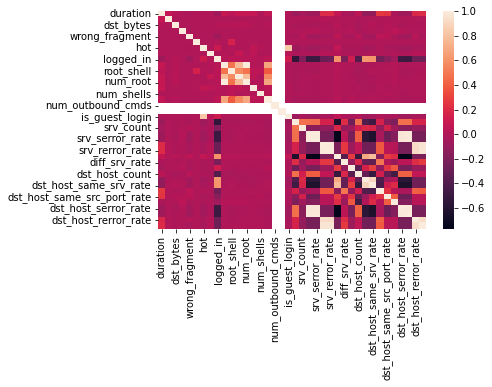

In [72]:
#heatmap of correlated values 
sns.heatmap(cm_df);


In [73]:
#evaluating target column "class" by counting the number of "anomaly" data & "normal" data
r1 = df.groupby('class').count().show()


+-------+-----+
|  class|count|
+-------+-----+
| normal|13449|
|anomaly|11743|
+-------+-----+



###Data Processing for ML Modeling


In [96]:
#selecting numerical column values as inputs that are the most likely to determine "anamolies"
assembler = VectorAssembler(inputCols=["serror_rate", "count", "same_srv_rate", "dst_host_srv_count",
                                       "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"],
                            outputCol="features")

In [97]:
output = assembler.transform(df)

In [98]:
#creating classIndex column with numerical values from class column
indexer = StringIndexer(inputCol="class", outputCol="classIndex")
indexed = indexer.fit(output).transform(output)
indexed.show()

+--------+-------------+----------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+--------------------+----------+
|duration|protocol_type|   service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|di

In [99]:
df_final = indexed.select('features','classIndex')

In [100]:
#train-test test split
train, test = df_final.randomSplit([0.7, 0.3])


###Random Forest Classifier

In [101]:
rfc = RandomForestClassifier(labelCol='classIndex', featuresCol= 'features')


In [102]:
rfc_model = rfc.fit(train)

In [103]:
#predictions with test data
rfc_predTest = rfc_model.transform(test)

#predictions with train data
rfc_predTrain = rfc_model.transform(train)


###Decision Tree Classifier

In [104]:
dtc = DecisionTreeClassifier(labelCol='classIndex', featuresCol= 'features')


In [105]:
dtc_model = dtc.fit(train)

In [106]:
#predictions with test data
dtc_predTest = dtc_model.transform(test)

#predictions with train data
dtc_predTrain = dtc_model.transform(train)

###Evaluation for Random Forest Classifier

In [107]:
# rfc_model feature importances
print (rfc_model.featureImportances)


(7,[0,1,2,3,4,5,6],[0.11142708767418989,0.1483295455201176,0.35734544779369654,0.1976664894961631,0.10151700159753647,0.044206231400883374,0.03950819651741292])


In [108]:
eval = MulticlassClassificationEvaluator(labelCol="classIndex", predictionCol="prediction", metricName="accuracy")

In [109]:
#accuracy with training data
acc = eval.evaluate(rfc_predTrain)
acc

0.9250893819874014

In [110]:
#accuracy with testing data
acc = eval.evaluate(rfc_predTest)
acc 

0.9280147932901862

###Evaluation for Decision Tree Classifier

In [111]:
print (dtc_model.featureImportances)


(7,[0,1,2,3,4,5,6],[0.012730072415243087,0.10501636408154191,0.7074783097969782,0.11485200473110874,0.015518127817577493,0.00436079595936746,0.04004432519818307])


In [112]:
#accuracy with training data
acc = eval.evaluate(dtc_predTrain)
acc

0.9189603314227343

In [113]:
#accuracy with testing data
acc = eval.evaluate(dtc_predTest)
acc

0.9222031435741646

###Conclusion

Overall, the goal of the project was to better understand threats to system networks by working with a dataset that contained anamolies. Firstly, the project evaluated the correlation of features and general statistics of the data. Next, several features where chosen to predict anomalies in the class column. A Random Forest Classifier and a Decision Tree Classifier were then used to predict values and most important features were ranked. Overall, the Random Forest Classifier had the slightly higher accuracy score of 92.80% compared to the Decision Tree Classifier that had a score of 92.22%.